##Download and Visualize Data

In [ ]:
# import dataset

# !wget https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip
# !mkdir emojis
# !unzip -q openmoji-72x72-color.zip -d ./emojis
!pip install tensorflow==2.4

     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 462 kB 44.7 MB/s 
     |████████████████████████████████| 2.9 MB 36.8 MB/s 
     |████████████████████████████████| 3.8 MB 34.9 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68717 sha256=6f5317f55e5aa751040c44da60592093766fee49518798a64060ed947ca797e3
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Suc

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 8BALL.png to 8BALL (1).png
Saving BASEBALL.png to BASEBALL (1).png
Saving BASKETBALL.png to BASKETBALL (1).png
Saving FOOTBALL.png to FOOTBALL (1).png
Saving LEATHERBALL.png to LEATHERBALL (1).png
Saving TENNISBALL.png to TENNISBALL (1).png
User uploaded file "8BALL.png" with length 2232 bytes
User uploaded file "BASEBALL.png" with length 2387 bytes
User uploaded file "BASKETBALL.png" with length 2132 bytes
User uploaded file "FOOTBALL.png" with length 2193 bytes
User uploaded file "LEATHERBALL.png" with length 7495 bytes
User uploaded file "TENNISBALL.png" with length 9556 bytes


In [ ]:
# import libraries
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Check if we are using TensorFlow 2.4')
print('Using TensorFlow version', tf.__version__)

Check if we are using TensorFlow 2.4
Using TensorFlow version 2.4.0


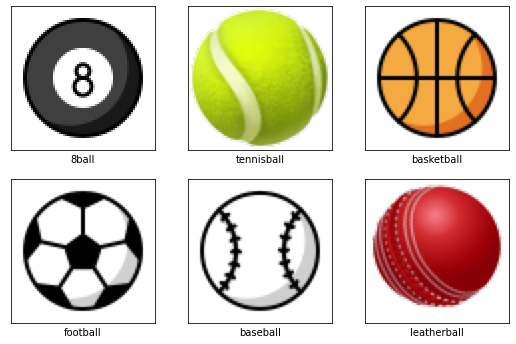

In [ ]:
# balls actually using in this project
balls = {
    0: {'name': '8ball', 'file': '8BALL.png'},
    1: {'name': 'tennisball', 'file': 'TENNISBALL.png'},
    2: {'name': 'basketball', 'file': 'BASKETBALL.png'},
    3: {'name': 'football', 'file': 'FOOTBALL.png'},
    4: {'name': 'baseball', 'file': 'BASEBALL.png'},
    5: {'name': 'leatherball', 'file': 'LEATHERBALL.png'}
}

# place images in larger images - help synthesis data for localization
plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(balls.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(e['file']))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

##Create Examples

In [ ]:
# loads balls and assign a key - image for each class in balls dictonary
for class_id, values in balls.items():
    png_file = Image.open(values['file']).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    balls[class_id]['image'] = new_file

In [ ]:
balls

{0: {'file': '8BALL.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FED1650D2D0>,
  'name': '8ball'},
 1: {'file': 'TENNISBALL.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FED1650D150>,
  'name': 'tennisball'},
 2: {'file': 'BASKETBALL.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FEDF031F5D0>,
  'name': 'basketball'},
 3: {'file': 'FOOTBALL.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FED1653A490>,
  'name': 'football'},
 4: {'file': 'BASEBALL.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FED1653A4D0>,
  'name': 'baseball'},
 5: {'file': 'LEATHERBALL.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FED1653A410>,
  'name': 'leatherball'}}

In [ ]:
def create_example():
  class_id = np.random.randint(0,6) # randomly choose a emoji
  image = np.ones((144,144,3)) * 255 # create a white image
  row = np.random.randint(0,72) # place image randomly
  col = np.random.randint(0,72) #place image ramdomly
  # place emoji in blank emoji
  image[row: row+72, col: col+72, :]= np.array(balls[class_id]['image'])
  # return synthesize image
  return image.astype('uint8'), class_id, (row+5)/144 , (col+5)/144      # +10 becuase there is a white space of around 10 pixels in cell 3
  # /144 is normalization of image

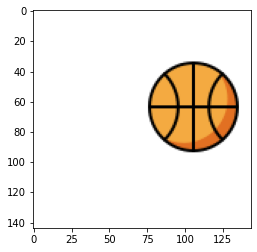

In [ ]:
image, class_id, row, col = create_example()
plt.imshow(image)

##Plot Bounding Boxes

In [ ]:
#plotting bounding boxes
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False): # pass image, ground truth row col coordinates, predicted coordinates(after training model we will have it)
  if norm:
    image *=255 # if norm is true, we will denormalize it
    image=image.astype('uint8')
  image = Image.fromarray(image) #to convert image array to pil image
  draw = ImageDraw.Draw(image)

  # extrating row and col from groud truth values
  row, col = gt_coords
  
  # denormalizing coords
  row *= 144
  col *= 144
  draw.rectangle((col, row, col+62, row+62), outline = 'green', width=3)  #+52 becuase iage is of 72 pixels becuase image has buffer of 10 pixels on each side.

  # now same for pred coords
  if len(pred_coords)==2:
    # extrating row and col from groud truth values
    row, col = pred_coords
  
    # denormalizing coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col+62, row+62), outline = 'red', width=3) 

  return image


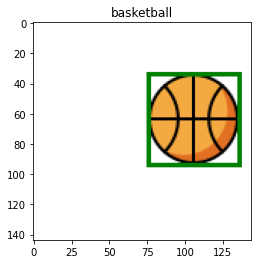

In [ ]:
image = plot_bounding_box(image, gt_coords = [row, col])
plt.imshow(image)
plt.title(balls[class_id]['name'])
plt.show()

##Data Generator

In [ ]:
# create endless stream of these randomly generated eg which we will use in our model
def data_generator(batch_size=16):
  #run in endless loop and create example and labels of batch size
  while True:
    x_batch = np.zeros((batch_size, 144, 144, 3)) # 144 = size of image
    y_batch = np.zeros((batch_size, 6)) #9= no of class ids
    bbox_batch = np.zeros((batch_size, 2)) #2 = for row and col values

    # create examples of no of batch size
    for i in range(0, batch_size):
      image, class_id, row, col = create_example()
      x_batch[i] = image/255   # normalize image and 255 because they are pixel values
      y_batch[i, class_id] = 1.0
      bbox_batch[i] = np.array([row,col])
    yield {'image':x_batch} ,{'class_out': y_batch, 'box_out': bbox_batch}

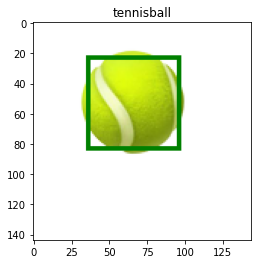

In [ ]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])  # to get the actual class id
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(balls[class_id]['name'])
plt.show()

##Model

In [ ]:
# CNN model
input_ = Input(shape=(144,144,3), name='image')

x = input_

# we will have totoal 5 convolutional blocks
for i in range(0,4):
  n_filters = 2**(4+i)
  x = Conv2D(n_filters, 3, activation='relu')(x) # (x) - input is x
  x = BatchNormalization()(x)
  x = MaxPool2D(2)(x) #pool size od 2x2

x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)

# now connect fully conected layer to our 2 output
class_out = Dense(6, activation='softmax', name = 'class_out')(x)   # 9= outputs as we have 9 clasess# for classifaction out, we use softmax
box_out = Dense(2, name = 'box_out')(x) # we dont specify any activation as it is regression output and it is linear by defualt

# now construct the model
model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()




Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 142, 142, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 142, 142, 16) 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 71, 71, 16)   0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

##Custom Metric: IoU

In [ ]:
# intersection over union is the evaluation metric 
# to measure the performance of the model - common in finding accuracy in object detector and object localizers
# iou is area of overlap [intesection of 2 boxes] between the predicted bounding box and actual values and 
# combining the areas of both minus intersection will give area of union
# divide area of overlap by area of union - IoU values, if 1 - prediction is accurate

In [ ]:
class IoU(tf.keras.metrics.Metric):
  def __init__(self, **kwargs):
    super(IoU, self).__init__(**kwargs)

    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
  
  def update_state(self, y_true, y_pred, sample_weight=None):
    def get_box(y):
      rows, cols = y[:, 0], y[:, 1]
      rows, cols = rows * 144, cols * 144
      y1, y2 = rows, rows + 62
      x1, x2 = cols, cols + 62
      return x1, y1, x2, y2
    
    def get_area(x1, y1, x2, y2):
      return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
    
    gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
    p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

    i_x1 = tf.maximum(gt_x1, p_x1)
    i_y1 = tf.maximum(gt_y1, p_y1)
    i_x2 = tf.minimum(gt_x2, p_x2)
    i_y2 = tf.minimum(gt_y2, p_y2)

    i_area = get_area(i_x1, i_y1, i_x2, i_y2)
    u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

    iou = tf.math.divide(i_area, u_area)
    self.num_ex.assign_add(1)
    self.total_iou.assign_add(tf.reduce_mean(iou))
    self.iou = tf.math.divide(self.total_iou, self.num_ex)
  
  def result(self):
    return self.iou
  
  def reset_state(self):
    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

## Task 8: Compile the Model

In [ ]:
model.compile(
    # specify the loss for fifferent outputs 
    loss={
        'class_out': 'categorical_crossentropy', # or classifaction output
        'box_out': 'mse' #for regression output
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),

    #set differnet metric for different output
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    }
)

##Custom Callback: Model Testing

In [ ]:
def test_model(model, test_datagen):
  example, label = next(test_datagen)
  x = example['image']
  y = label['class_out']
  box = label['box_out']

  pred_y, pred_box = model.predict(x)

  pred_coords = pred_box[0]  # [0] beacuse we want only one example
  gt_coords = box[0]
  pred_class = np.argmax(pred_y[0])
  image = x[0]

  gt = balls[np.argmax(y[0])]['name']
  pred_class_name = balls[pred_class]['name']

  image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
  
  # set text colors of labels
  color = 'green' if gt == pred_class_name else 'red'

  plt.imshow(image)
  plt.xlabel(f'Pred: {pred_class_name}', color=color)
  plt.ylabel(f'GT: {gt}', color=color)
  plt.xticks([])
  plt.yticks([])

In [ ]:
def test(model):
  test_datagen = data_generator(1) #1 = batch size is 1


  plt.figure(figsize=(16, 4))

  # plot 6 images
  for i in range(0, 6):
    plt.subplot(1, 6, i + 1)
    test_model(model, test_datagen)
  plt.show()

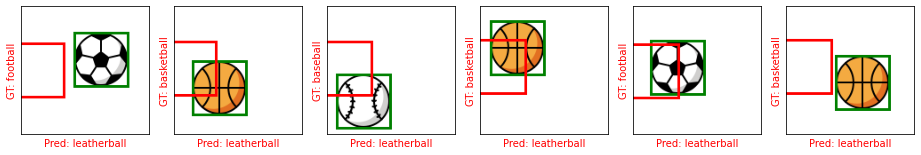

In [ ]:
test(model)

In [ ]:
# create a custom call back
class ShowTestImages(tf.keras.callbacks.Callback): # to customize Callback class
  def on_epoch_end(self, epoch, logs=None): # on epoch end during the training, run test funtion
    test(self.model) 

##Model Training

Epoch 1/100
500/500 [==============================] - 13s 24ms/step - loss: 5.7395 - class_out_loss: 0.6591 - box_out_loss: 5.0804 - class_out_accuracy: 0.7987 - box_out_iou: 0.1360


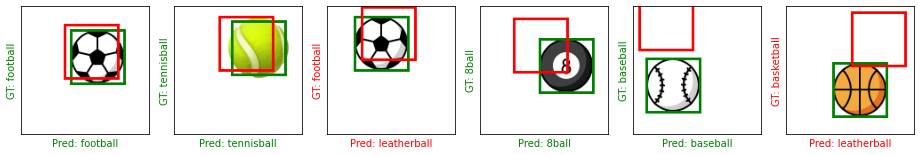

Epoch 2/100
500/500 [==============================] - 12s 24ms/step - loss: 0.0088 - class_out_loss: 0.0017 - box_out_loss: 0.0072 - class_out_accuracy: 1.0000 - box_out_iou: 0.5889


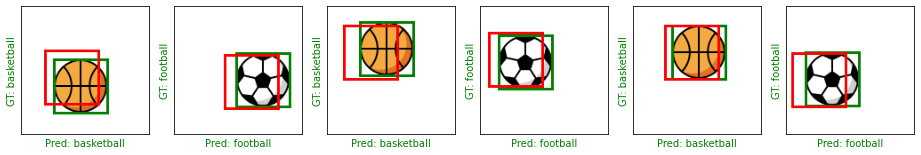

Epoch 3/100
500/500 [==============================] - 12s 25ms/step - loss: 0.0035 - class_out_loss: 6.3001e-04 - box_out_loss: 0.0029 - class_out_accuracy: 1.0000 - box_out_iou: 0.7027


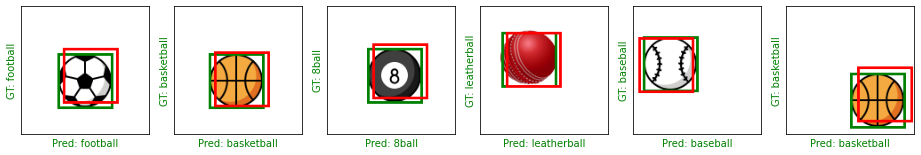

Epoch 4/100
500/500 [==============================] - 12s 25ms/step - loss: 0.0019 - class_out_loss: 3.1236e-04 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - box_out_iou: 0.7644


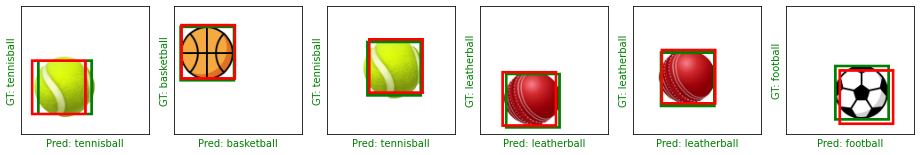

Epoch 5/100
500/500 [==============================] - 12s 25ms/step - loss: 9.1429e-04 - class_out_loss: 2.2593e-04 - box_out_loss: 6.8836e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8375


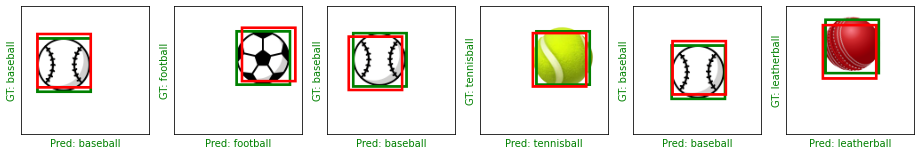

Epoch 6/100
500/500 [==============================] - 12s 25ms/step - loss: 7.4677e-04 - class_out_loss: 1.4700e-04 - box_out_loss: 5.9976e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8463


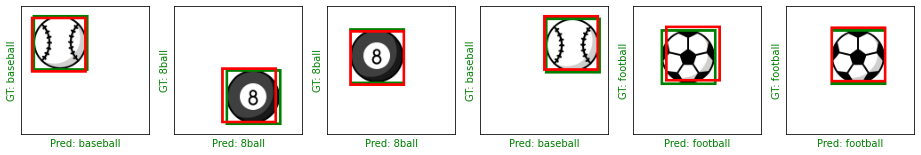

Epoch 7/100
500/500 [==============================] - 12s 25ms/step - loss: 0.0020 - class_out_loss: 0.0013 - box_out_loss: 6.5552e-04 - class_out_accuracy: 0.9997 - box_out_iou: 0.8403


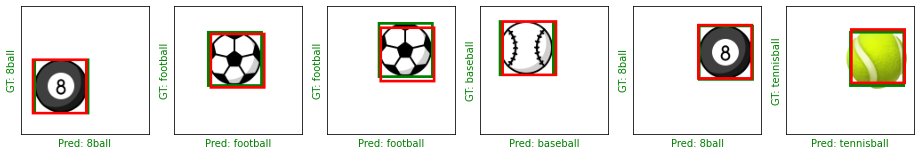

Epoch 8/100
500/500 [==============================] - 13s 26ms/step - loss: 7.0534e-04 - class_out_loss: 1.8393e-04 - box_out_loss: 5.2141e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8572


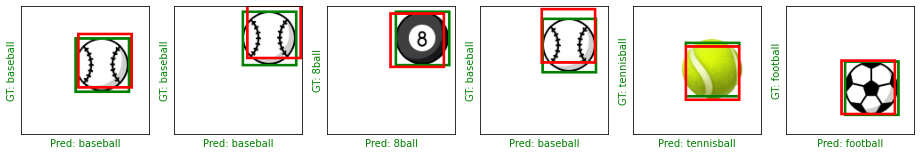

Epoch 9/100
500/500 [==============================] - 13s 26ms/step - loss: 0.0017 - class_out_loss: 0.0011 - box_out_loss: 5.4991e-04 - class_out_accuracy: 0.9997 - box_out_iou: 0.8546


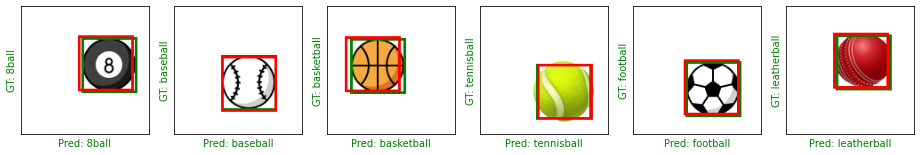

Epoch 10/100
500/500 [==============================] - 13s 25ms/step - loss: 4.9440e-04 - class_out_loss: 9.7143e-05 - box_out_loss: 3.9726e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8741


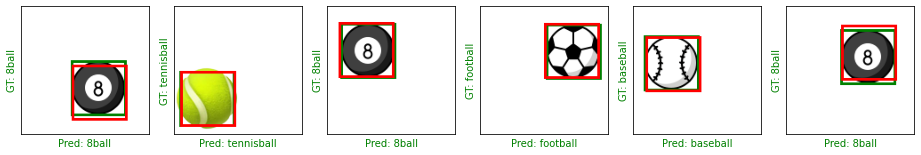

Epoch 11/100
500/500 [==============================] - 13s 26ms/step - loss: 4.3102e-04 - class_out_loss: 8.0618e-05 - box_out_loss: 3.5041e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8816


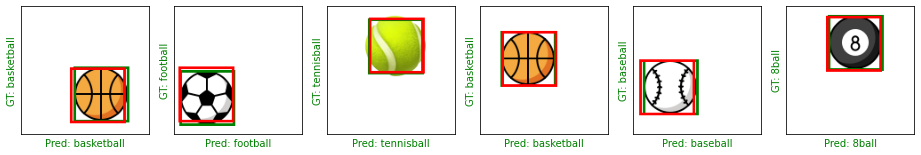

Epoch 12/100
500/500 [==============================] - 13s 26ms/step - loss: 4.0492e-04 - class_out_loss: 7.0611e-05 - box_out_loss: 3.3431e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8842


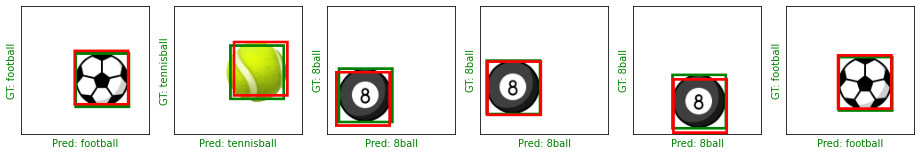

Epoch 13/100
500/500 [==============================] - 13s 27ms/step - loss: 3.8628e-04 - class_out_loss: 7.5328e-05 - box_out_loss: 3.1095e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8864


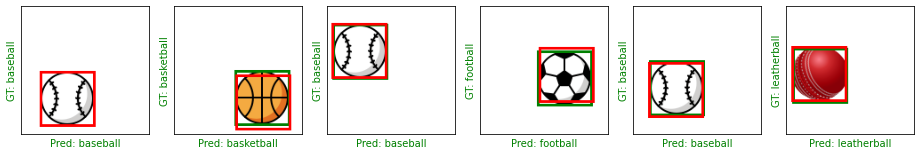

Epoch 14/100
500/500 [==============================] - 13s 27ms/step - loss: 3.8424e-04 - class_out_loss: 7.3570e-05 - box_out_loss: 3.1067e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8879


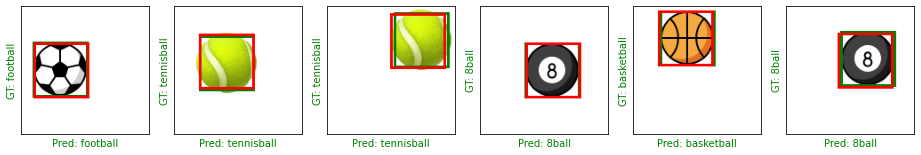

Epoch 15/100
500/500 [==============================] - 14s 28ms/step - loss: 3.3730e-04 - class_out_loss: 5.9345e-05 - box_out_loss: 2.7796e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8929


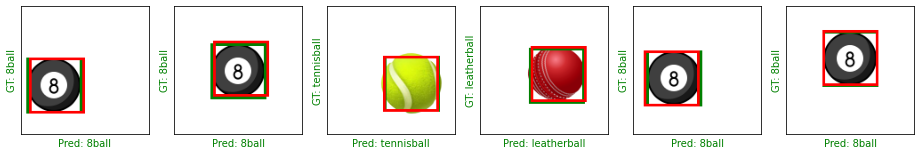

Epoch 16/100
500/500 [==============================] - 15s 29ms/step - loss: 3.0895e-04 - class_out_loss: 5.2164e-05 - box_out_loss: 2.5679e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8964


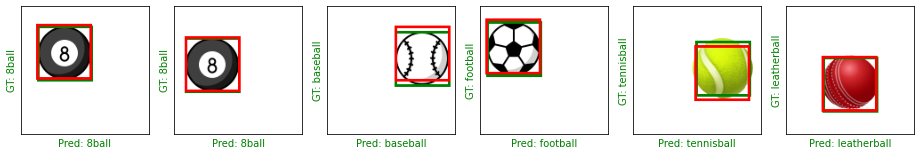

Epoch 17/100
500/500 [==============================] - 15s 30ms/step - loss: 2.9355e-04 - class_out_loss: 3.9950e-05 - box_out_loss: 2.5360e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8977


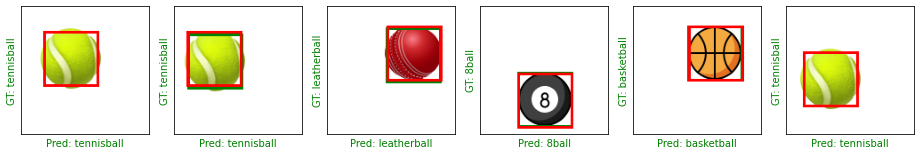

Epoch 18/100
500/500 [==============================] - 15s 30ms/step - loss: 2.8637e-04 - class_out_loss: 4.4064e-05 - box_out_loss: 2.4230e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8995


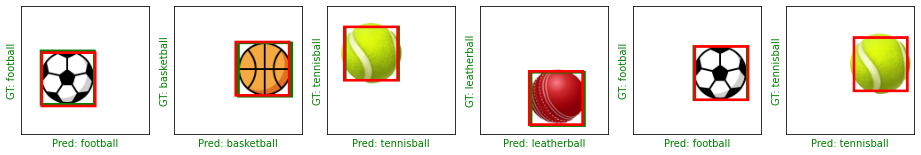

Epoch 19/100
500/500 [==============================] - 15s 30ms/step - loss: 2.6712e-04 - class_out_loss: 3.5693e-05 - box_out_loss: 2.3142e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9011


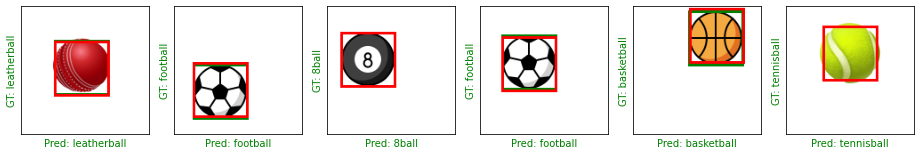

Epoch 20/100
500/500 [==============================] - 15s 30ms/step - loss: 2.6180e-04 - class_out_loss: 3.8473e-05 - box_out_loss: 2.2333e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9032


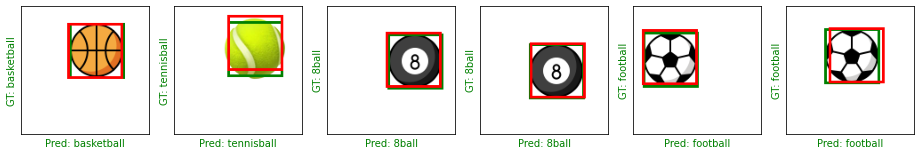

Epoch 21/100
500/500 [==============================] - 15s 30ms/step - loss: 2.8990e-04 - class_out_loss: 5.0171e-05 - box_out_loss: 2.3973e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9006


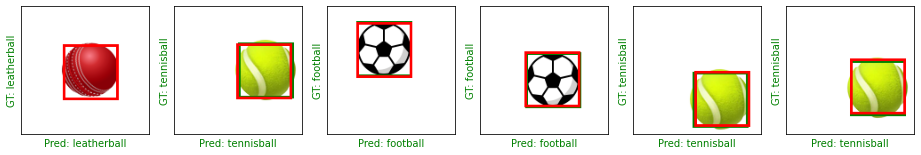

Epoch 22/100
500/500 [==============================] - 16s 32ms/step - loss: 2.6239e-04 - class_out_loss: 4.6130e-05 - box_out_loss: 2.1626e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9037


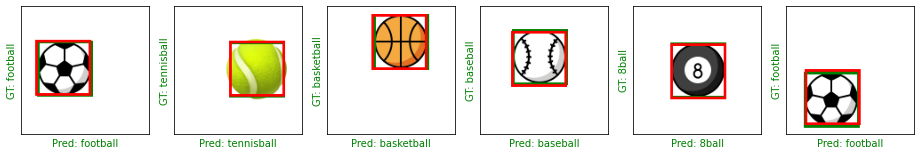

Epoch 23/100
500/500 [==============================] - 16s 32ms/step - loss: 2.5693e-04 - class_out_loss: 4.0302e-05 - box_out_loss: 2.1662e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9042


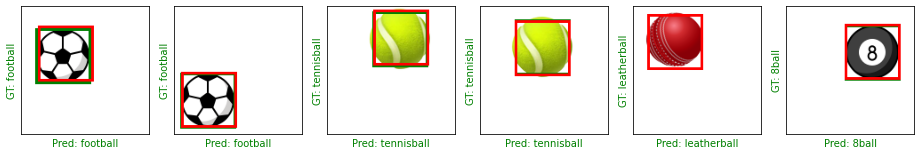

Epoch 24/100
500/500 [==============================] - 16s 32ms/step - loss: 2.6677e-04 - class_out_loss: 5.4924e-05 - box_out_loss: 2.1185e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9043


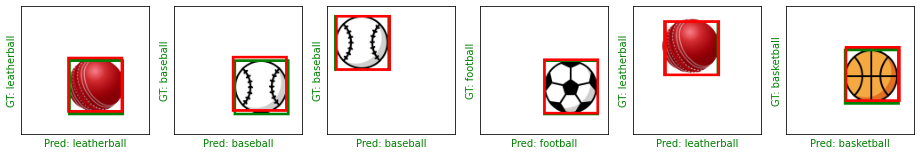

Epoch 25/100
500/500 [==============================] - 16s 32ms/step - loss: 2.3737e-04 - class_out_loss: 3.0686e-05 - box_out_loss: 2.0668e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9064


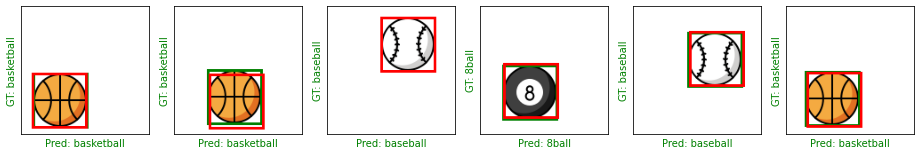

Epoch 26/100
500/500 [==============================] - 16s 32ms/step - loss: 2.4427e-04 - class_out_loss: 3.5307e-05 - box_out_loss: 2.0896e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9056


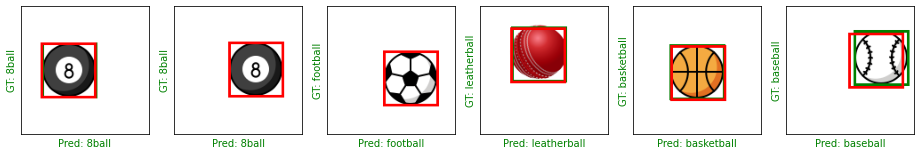

Epoch 27/100
500/500 [==============================] - 16s 32ms/step - loss: 2.4596e-04 - class_out_loss: 3.3021e-05 - box_out_loss: 2.1294e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9051


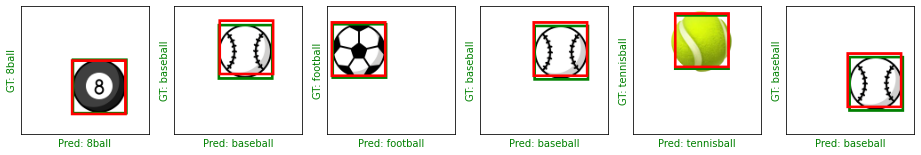

Epoch 28/100
500/500 [==============================] - 16s 32ms/step - loss: 2.5350e-04 - class_out_loss: 4.0388e-05 - box_out_loss: 2.1311e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9055


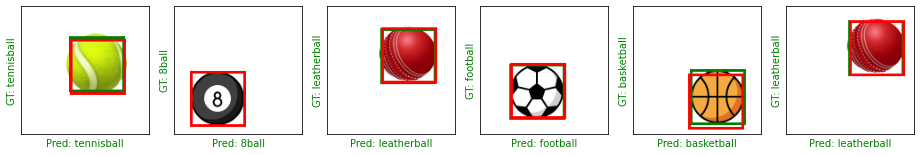

Epoch 29/100
500/500 [==============================] - 16s 32ms/step - loss: 2.5304e-04 - class_out_loss: 4.2398e-05 - box_out_loss: 2.1064e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9051


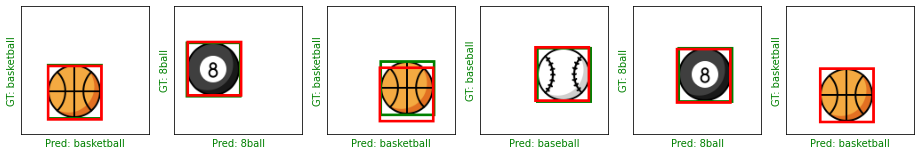

Epoch 30/100
500/500 [==============================] - 16s 33ms/step - loss: 2.4803e-04 - class_out_loss: 3.3764e-05 - box_out_loss: 2.1426e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9050


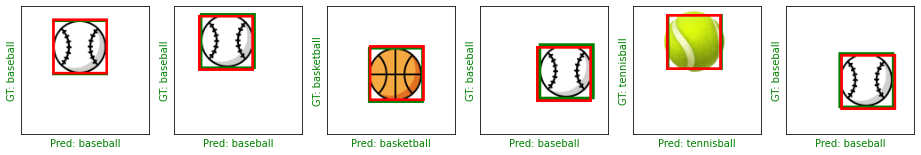

Epoch 31/100
500/500 [==============================] - 17s 33ms/step - loss: 2.3137e-04 - class_out_loss: 3.2976e-05 - box_out_loss: 1.9839e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9080


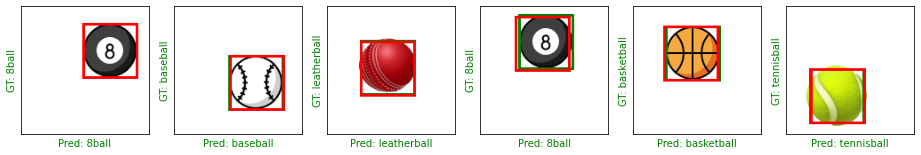

Epoch 32/100
500/500 [==============================] - 17s 33ms/step - loss: 2.5517e-04 - class_out_loss: 4.1930e-05 - box_out_loss: 2.1324e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9051


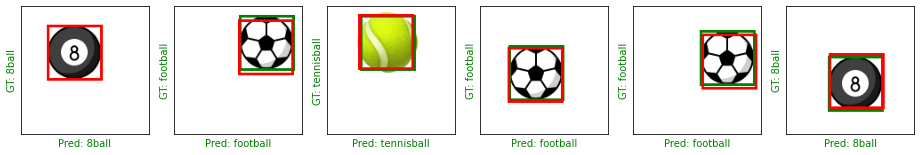

Epoch 33/100
500/500 [==============================] - 17s 33ms/step - loss: 2.4427e-04 - class_out_loss: 3.4130e-05 - box_out_loss: 2.1014e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9056


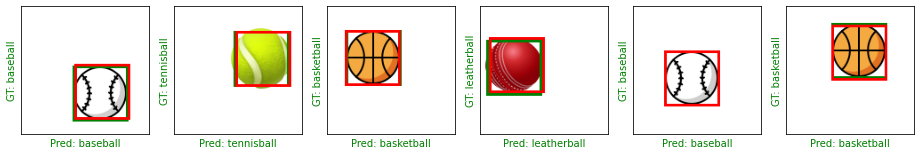

Epoch 34/100
500/500 [==============================] - 17s 34ms/step - loss: 2.3497e-04 - class_out_loss: 3.2729e-05 - box_out_loss: 2.0224e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9069


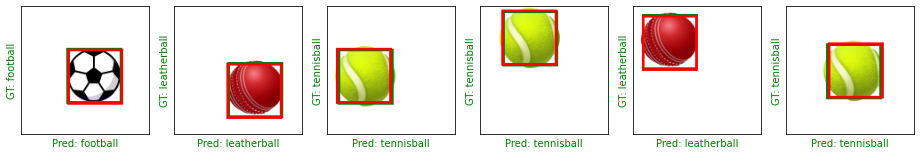

Epoch 35/100
500/500 [==============================] - 17s 34ms/step - loss: 2.5802e-04 - class_out_loss: 4.5981e-05 - box_out_loss: 2.1204e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9054


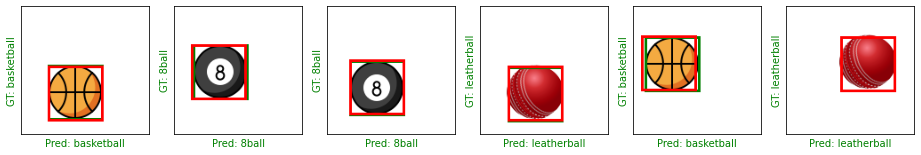

Epoch 36/100
500/500 [==============================] - 17s 35ms/step - loss: 2.5018e-04 - class_out_loss: 3.6062e-05 - box_out_loss: 2.1412e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9053


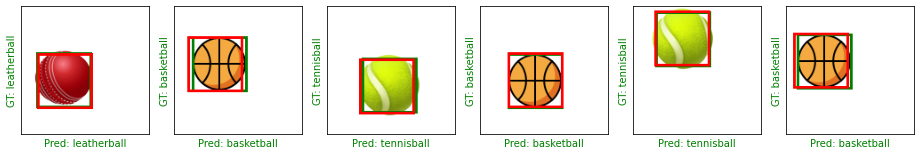

Epoch 37/100
500/500 [==============================] - 17s 35ms/step - loss: 2.6270e-04 - class_out_loss: 4.4450e-05 - box_out_loss: 2.1825e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.9056


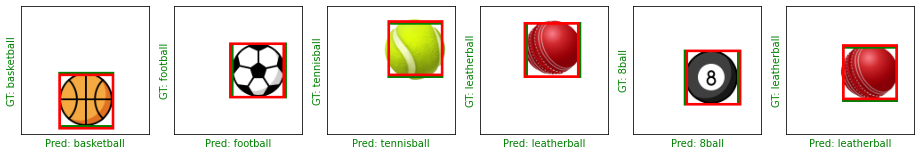

In [ ]:
def lr_schedule(epoch, lr):
  if (epoch+1)%5 == 0:
    lr *= 0.2
  return max(lr, 3e-7)

_ = model.fit(
    data_generator(),
    epochs = 100,
    steps_per_epoch = 500,
    callbacks=[
               ShowTestImages(),
               tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'), 
               #stop is iou values does not incraese for 4 consective epochs
               
               tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)